# Facial Gesture Classifier

#### Dependencies

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import torch
import torchvision

import os
import shutil
import PIL
import copy
from sklearn.metrics import confusion_matrix


#### Download dataset

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge


 95% 272M/285M [00:02<00:00, 106MB/s]
100% 285M/285M [00:02<00:00, 110MB/s]


#### Load dataset as pandas dataframe

In [4]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip
icml_faces = pd.read_csv('icml_face_data.csv')

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


#### Helpers

In [5]:
def to_t(tensor):
  return tensor.to(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

def to_cpu(tensor):
  return tensor.to(torch.device('cpu'))

In [6]:
emotions_to_id = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral' }

#### Display images with labels

In [ ]:
icml_faces = pd.read_csv('icml_face_data.csv')
icml_faces.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


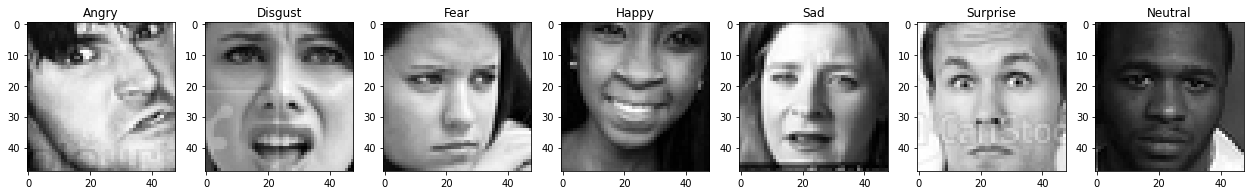

In [ ]:
def get_image_by_class(df,img_class):

  img_row = None
  for i in range(len(df)-1, 0, -1):
    if df['emotion'][i] == img_class:
        img_row = df.iloc[i]
        break

  img = np.fromstring(img_row[' pixels'], sep=' ')
  img = np.reshape(img, (48, 48))

  return img


plt.figure(0, figsize=(25,100))

for i in range(len(emotions_to_id)):

    plt.subplot(1,8,i+1)
    plt.title(emotions_to_id[i])
    plt.imshow(get_image_by_class(icml_faces,i), cmap='gray')


#### Preprocessing data

Make training and validation folders with emotion subfolders.

In [7]:
for folder_name in ["images", "images/training", "images/validation", "images/test"]:
  if not os.path.exists(folder_name):
    os.mkdir(folder_name)

for emotion in emotions_to_id:
  for folder_name in ["images/training/", "images/validation/", "images/test/"]:
    if not os.path.exists(folder_name + str(emotion)):
      os.mkdir(folder_name + str(emotion))

Split data into training, validation and test sets. Save images to appropriate folders.

In [8]:
def prepare_data(df, set_subfolder):
  imgs = []
  
  for i in df.index:
    img = np.fromstring(df.loc[i, ' pixels'], sep=' ')
    img = np.reshape(img, (48, 48))
    image = PIL.Image.fromarray(img.astype(np.uint8))
    imgs.append(image)
    image.save('images/'+set_subfolder+"/"+str(df['emotion'][i])+"/"+str(i)+'.png')


In [9]:
data_set = pd.read_csv('icml_face_data.csv')

train_data = data_set[data_set[' Usage'] == "Training"]
validation_data = data_set[data_set[' Usage'] == "PublicTest"]
test_data = data_set[data_set[' Usage'] == "PrivateTest"]


prepare_data(train_data, 'training')
prepare_data(validation_data, 'validation')
prepare_data(test_data, 'test')

#### Image Augmentation and DataLoaders

In [ ]:
# shutil.rmtree('images')

To normalize images we must first find the mean and standard deviation of the images in the training set.

In [10]:
# transformations going to be applied to training data
trainDataTransforms = torchvision.transforms.Compose(
  [
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.RandomResizedCrop(size=48),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
  ]
)

# load training images (in PIL form)
train_data = torchvision.datasets.ImageFolder(root='images/training',transform=trainDataTransforms)

imgs = torch.stack([img for img, _ in train_data], dim=3)

# calculate mean and std for imgs tensor containing all training images
training_set_mean = torch.mean(imgs).item()
training_set_std = torch.std(imgs).item()

print(training_set_mean, training_set_std)

0.5330070853233337 0.2321745753288269


Now add normalization to the transformations of the train, validation, and test data with the calculated mean and std.

In [11]:
trainDataTransforms = torchvision.transforms.Compose(
  [
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.RandomResizedCrop(size=48),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([training_set_mean],[training_set_std])  
  ]
)

validationTestDataTransforms = torchvision.transforms.Compose(
  [ 
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize((48,48)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([training_set_mean],[training_set_std])  
  ]
)

Load data from images folder and apply transformations.

In [12]:
train_data = torchvision.datasets.ImageFolder(root='images/training',transform=trainDataTransforms)
validation_data = torchvision.datasets.ImageFolder(root='images/validation', transform=validationTestDataTransforms)
test_data = torchvision.datasets.ImageFolder(root='images/test', transform=validationTestDataTransforms)

DataLoaders.

In [13]:
BATCH_SIZE = 64

trainDataLoader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validationDataLoader = torch.utils.data.DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
testDataLoader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

data_loaders = {'Train': trainDataLoader, 'Validation': validationDataLoader, 'Test': testDataLoader}

Validate that images have been normalized; mean is ~0 and standard devitation is ~1.

In [14]:
imgs = torch.stack([img for img, _ in train_data], dim=3)
print(imgs.mean().item(),imgs.std().item())

0.0002459448587615043 1.0000207424163818


## Model Architecture

#### Custom model

Reached ~56% validation accuracy with custom model architecture.

In [31]:
class CustomModel(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
    self.convolutionalLayers = torch.nn.Sequential(
        
      torch.nn.Conv2d(3, 32, kernel_size=3),
      torch.nn.ReLU(),
      torch.nn.Conv2d(32, 64, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(2),

      torch.nn.Conv2d(64, 128, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.Conv2d(128, 128, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(2),

      torch.nn.Conv2d(128, 64, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.Conv2d(64, 32, kernel_size=3, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(2),

      torch.nn.ReLU(),

      torch.nn.Flatten()
    )

    self.linearLayers = torch.nn.Sequential(
      torch.nn.Linear(800, 512),
      torch.nn.ReLU(),
      torch.nn.Dropout(0.5),
      torch.nn.Linear(512, 64),
      torch.nn.ReLU(),
      torch.nn.Dropout(0.5),
      torch.nn.Linear(64, 7),
    ) 

    self.to(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
        
  def forward(self, x):

    # Convolutional layers
    out = self.convolutionalLayers(x)

    # Linear layers
    out = self.linearLayers(out)
    
    return out
    

custom_facial_expression_model = CustomModel()

custom_model_loss_fn = torch.nn.CrossEntropyLoss()
custom_model_optimizer = torch.optim.Adam(custom_facial_expression_model.parameters())

#### Pretrained model

Employing transfer learning using ResNet-50 pretrained model.


In [32]:
facial_expression_model = torchvision.models.resnet50(weights="ResNet50_Weights.DEFAULT")
num_ftrs = facial_expression_model.fc.in_features

# classification head
facial_expression_model.fc =  torch.nn.Sequential(
  torch.nn.Linear(num_ftrs, 64),
  torch.nn.ReLU(),
  torch.nn.Linear(64, 7),
)

# model to gpu if available
facial_expression_model.to(torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

# loss function - cross entropy loss
# optimizer - Stochastic gradient descent
model_loss_fn = torch.nn.CrossEntropyLoss()
model_optimizer = torch.optim.SGD(facial_expression_model.parameters(), lr=1e-2, momentum=0.9)

I initially tried freezing different combinations of convolutional layers in the ResNet-50 model. This resulted in the model performing worse. It is my hypothesis that this is likely because some of the features found in the images of the faces do not resemble those found in the dataset which this model was pretrained on. To improve the accuracy of this model we could find a model which was pretrained for some task on images of humans or faces.

#### Training

In [33]:
# For visualizing model performance

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [34]:
def train_model(model, loss_fn, optimizer, num_epochs):

  best_model_params = copy.deepcopy(model.state_dict())
  highest_accuracy = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    print('-' * 7)

    for phase in ["Train", "Validation"]:
      # set models mode
      if phase == "Train":
        model.train() 
      else:
        model.eval() 

      # for calculating model loss and accuracy for current epoch    
      total_loss = 0
      num_predictions = 0
      num_correct_predictions = 0

      for images, labels in data_loaders[phase]:
        # convert tensors to gpu if available
        images = to_t(images)
        labels = to_t(labels)

        # don't accumulate gradients
        optimizer.zero_grad()

        # only calculate gradients for train data
        with torch.set_grad_enabled(phase == 'Train'):
          # complete forward pass with images in current batch
          outputs = model.forward(images)
          # calculate predicted emotions for current batch
          predictions = torch.argmax(outputs.data, 1)
          # calculate loss for current batch
          loss = loss_fn(outputs, labels)

          # only compute gradients and step parameters for training data 
          if phase == 'Train':
            # compute gradients using back propagation
            loss.backward()
            # step model parameters based on calculated gradients
            optimizer.step()

        # update model loss for current epoch
        total_loss += loss.item() * labels.size(0)
        # update total num of predictions and num correct predicitons for current batch
        num_predictions += labels.size(0)
        num_correct_predictions += (predictions == labels).sum()

      # calculate model loss and accuracy for current epoch
      epoch_loss = total_loss / num_predictions
      epoch_accuracy = (100 * num_correct_predictions / num_predictions).item()

      if(phase == 'Train'):
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
      else:
        validation_losses.append(epoch_loss)
        validation_accuracies.append(epoch_accuracy)
        # if our model is performing at its best (for validation data), update best parameters and highest accuracy
        if epoch_accuracy > highest_accuracy:
          highest_accuracy = epoch_accuracy
          best_model_params = copy.deepcopy(model.state_dict())

      # print performance for current epoch
      print(f'{phase}')
      print(f'Loss: {epoch_loss:.4f}   Acc: {epoch_accuracy:.4f}')
    
    print()
    print()
  
  # load best performing model parameters
  model.load_state_dict(best_model_params)
  return model


First training custom model to compare results with pretrained model.

In [35]:
custom_model = train_model(custom_facial_expression_model, custom_model_loss_fn, custom_model_optimizer, 30)

Epoch 1
-------
Train
Loss: 1.8235   Acc: 24.1144
Validation
Loss: 1.7857   Acc: 24.9373


Epoch 2
-------
Train
Loss: 1.7954   Acc: 25.1977
Validation
Loss: 1.7310   Acc: 29.1725


Epoch 3
-------
Train
Loss: 1.7523   Acc: 27.8589
Validation
Loss: 1.6693   Acc: 32.3767


Epoch 4
-------
Train
Loss: 1.6916   Acc: 30.5723
Validation
Loss: 1.5355   Acc: 37.3920


Epoch 5
-------
Train
Loss: 1.6333   Acc: 33.7002
Validation
Loss: 1.4349   Acc: 43.2154


Epoch 6
-------
Train
Loss: 1.6011   Acc: 35.5150
Validation
Loss: 1.4495   Acc: 43.9398


Epoch 7
-------
Train
Loss: 1.5733   Acc: 37.4064
Validation
Loss: 1.3758   Acc: 46.9212


Epoch 8
-------
Train
Loss: 1.5414   Acc: 38.8589
Validation
Loss: 1.3401   Acc: 47.3948


Epoch 9
-------
Train
Loss: 1.5154   Acc: 40.7224
Validation
Loss: 1.3126   Acc: 49.2059


Epoch 10
-------
Train
Loss: 1.4956   Acc: 41.1439
Validation
Loss: 1.3021   Acc: 49.8746


Epoch 11
-------
Train
Loss: 1.4903   Acc: 41.9137
Validation
Loss: 1.2707   Acc: 50.4597

Custom model reaches validation accuracy of ~54% on validation data.

Train ResNet model for 30 epochs.

In [37]:
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [38]:
facial_expression_model = train_model(facial_expression_model, model_loss_fn, model_optimizer, 30)

Epoch 1
-------
Train
Loss: 1.5987   Acc: 36.5112
Validation
Loss: 1.3909   Acc: 48.8158


Epoch 2
-------
Train
Loss: 1.3867   Acc: 46.4279
Validation
Loss: 1.1907   Acc: 54.4999


Epoch 3
-------
Train
Loss: 1.3041   Acc: 50.0226
Validation
Loss: 1.1467   Acc: 56.5617


Epoch 4
-------
Train
Loss: 1.2478   Acc: 52.1579
Validation
Loss: 1.1246   Acc: 57.9270


Epoch 5
-------
Train
Loss: 1.2169   Acc: 53.5929
Validation
Loss: 1.0985   Acc: 58.9579


Epoch 6
-------
Train
Loss: 1.1835   Acc: 54.7807
Validation
Loss: 1.1152   Acc: 58.1220


Epoch 7
-------
Train
Loss: 1.1596   Acc: 55.8222
Validation
Loss: 1.0649   Acc: 60.1560


Epoch 8
-------
Train
Loss: 1.1431   Acc: 56.4248
Validation
Loss: 1.0603   Acc: 60.9362


Epoch 9
-------
Train
Loss: 1.1297   Acc: 57.1737
Validation
Loss: 1.0393   Acc: 61.1591


Epoch 10
-------
Train
Loss: 1.1145   Acc: 57.9470
Validation
Loss: 1.0286   Acc: 62.4129


Epoch 11
-------
Train
Loss: 1.0923   Acc: 58.5809
Validation
Loss: 1.0537   Acc: 61.5492

Employing transfer learning with the pretrained ResNet-50 model resulted in a ~9% increase in validation accuracy from my custom model.

Save model parameters

In [39]:
if not os.path.exists("model"):
  os.mkdir("model")
torch.save(facial_expression_model.state_dict(), 'model/facial_expression_model.pth')

## Results

In [40]:
def plot_losses():
  plt.plot(train_losses, '-bx')
  plt.plot(validation_losses, '-rx')
  plt.xlabel('Epoch #')
  plt.ylabel('Loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs Epoch #');

def plot_accuracies():
  plt.plot(train_accuracies, '-bx')
  plt.plot(validation_accuracies, '-rx')
  plt.xlabel('Epoch #')
  plt.ylabel('Accuracy')
  plt.legend(['Training', 'Validation'])
  plt.title('Accuracy vs Epoch #');

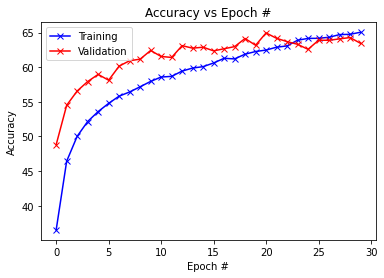

In [41]:
plot_accuracies()

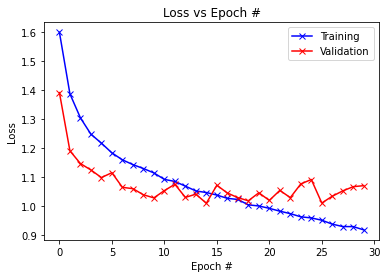

In [42]:
plot_losses()

#### Evaluate Performance on Test Data

In [100]:
incorrect_predictions = {"images":[], "labels":[], "predictions":[]}
# keep track of image labels and predicted labels for confusion matrix
true_and_predicted_labels = {"true":[], "predictions": []}

def calculate_accuracy(model):

  num_correct_predictions = 0
  num_predictions = 0

  for images, labels in data_loaders['Test']:
    # convert tensors to gpu if available
    images = to_t(images)
    labels = to_t(labels)
    
    # complete forward pass with images in current batch
    outputs = model(images)

    # calculate predicted emotions for current batch
    predictions = torch.argmax(outputs.data, 1)

    # save image labels and predictions for confusion matrix
    for i in range(len(outputs)):
      true_and_predicted_labels["true"].append(labels.cpu().numpy()[i])
      true_and_predicted_labels["predictions"].append(predictions.cpu().numpy()[i])

    # update total num of predictions and num correct predicitons for current batch
    num_predictions += labels.size(0)
    num_correct_predictions += (predictions == labels).sum()
    
    # save images and their labels and predictions for later analysis
    incorrect_predictions["images"].append(images[predictions!=labels])
    incorrect_predictions["labels"].append(labels[predictions!=labels])
    incorrect_predictions["predictions"].append(predictions[predictions!=labels])

  # calculate model accuracy for current epoch
  train_accuracy = 100 * num_correct_predictions / num_predictions

  return train_accuracy

Final Results

In [105]:
test_accuracy = calculate_accuracy(facial_expression_model)

print("\nFINAL RESULTS")
print(f"Model accuracy on test data: {test_accuracy:.4f}%")


FINAL RESULTS
Model accuracy on test data: 64.5305%


Displaying confusion matrix.

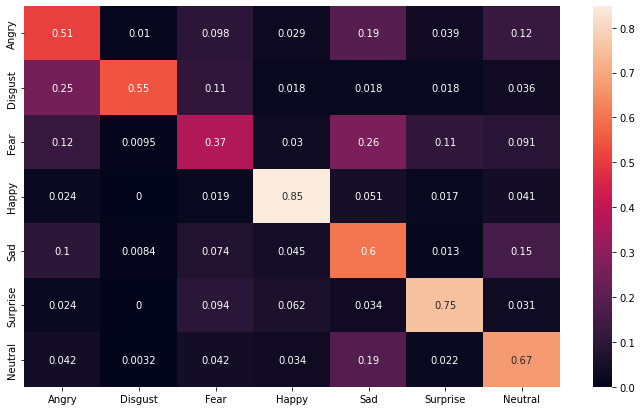

In [187]:
cfm = confusion_matrix(true_and_predicted_labels["true"], true_and_predicted_labels["predictions"])
# normalize
cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]

cfm_df = pd.DataFrame(cfm, index = 
                      [emotion for emotion in emotions_to_id.values()],
                      columns = [emotion for emotion in emotions_to_id.values()])

plt.figure(figsize = (12,7))
sn.heatmap(cfm_df, annot=True)

**Confusion Matrix Takeaways**

Model does the best with images of happy faces. Model does the worst with images of fearful faces.



Angry can be labeled as sad, disgust can be labeled as angry, fear is often labeled as sad and can be labeled as angry and suprise, sad can be labeled as neutral, and neutral can be labeled as sad. These all seem like reasonable mistakes.

#### Display incorrect predictions

We can see it looks like some of these images have been mislabeled or their labels are indeterminate to the human eye.



Prediction: Angry
Label: Neutral


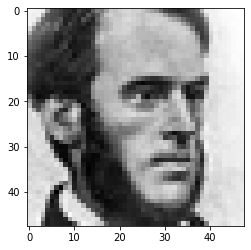

Prediction: Sad
Label: Happy


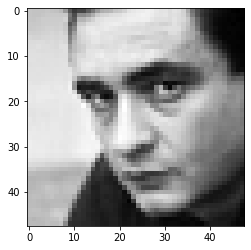

Prediction: Happy
Label: Sad


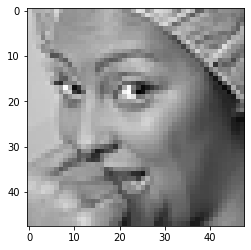

Prediction: Sad
Label: Angry


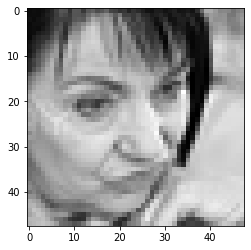

Prediction: Angry
Label: Neutral


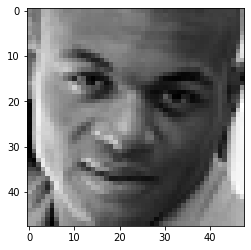

Prediction: Angry
Label: Sad


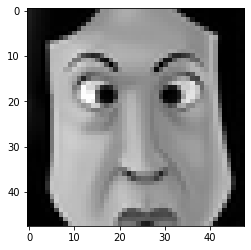

Prediction: Neutral
Label: Sad


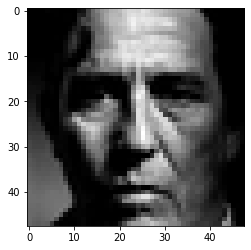

Prediction: Surprise
Label: Fear


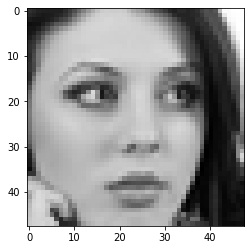

Prediction: Angry
Label: Fear


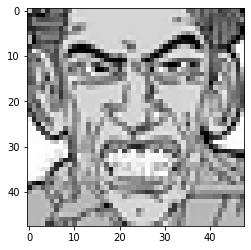

Prediction: Sad
Label: Surprise


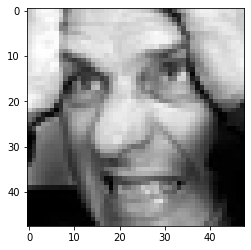

In [188]:
incorrect_predictions["labels"]  = [label.item() for label in incorrect_predictions["labels"][0]]
incorrect_predictions["predictions"]  = [prediction.item() for prediction in incorrect_predictions["predictions"][0]]

# print the first ten images that were wrongly classified
for i in range (10):
  print("Prediction: " + emotions_to_id[incorrect_predictions["predictions"][i]])
  print("Label: " + emotions_to_id[incorrect_predictions["labels"][i]])
  plt.imshow(to_cpu(incorrect_predictions["images"][i][0]).numpy()[0], cmap='gray')
  plt.show()

#### Personal test

Predict the emotions for some images from Google.
Model looks to be performing well. Note the emotions of these people are fairly obvious to the human eye.

In [ ]:
imgs = []
for i in range(7):
  img = to_t(validationTestDataTransforms(PIL.Image.open('my_emotions/'+str(i)+'.png')))
  imgs.append(img)
  
imgs = torch.stack(imgs)

In [ ]:
predictions = torch.argmax(facial_expression_model(imgs), 1)
predictions = [prediction.item() for prediction in predictions]

Happy


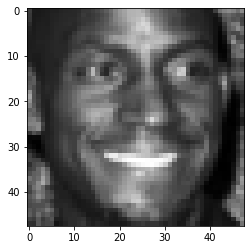

Angry


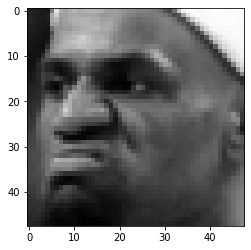

Sad


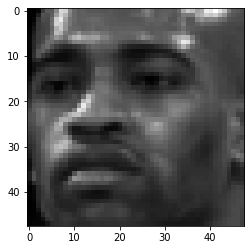

Disgust


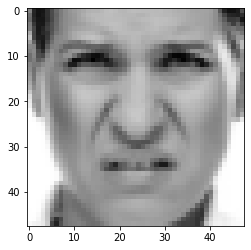

Surprise


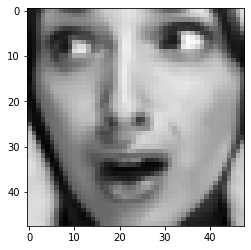

Angry


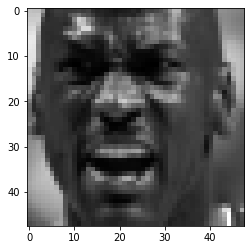

Angry


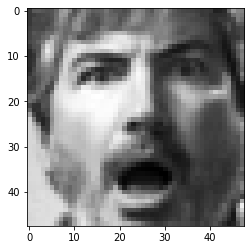

In [ ]:
imgs = to_cpu(imgs)

for i, prediction in enumerate(predictions):
  print (emotions_to_id[prediction])
  plt.imshow(imgs.numpy()[i][0], cmap='gray')
  plt.show()
